RECORDAR DESZIPEAR PROPERATTI.ZIP

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("properatti.csv", index_col=0)
data.shape

(121220, 25)

In [267]:
data.dtypes

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object

In [268]:
data.rooms.value_counts()

3.0     12567
2.0     12433
4.0      7937
1.0      7377
5.0      3782
6.0      1403
7.0       770
8.0       409
10.0      226
9.0       184
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
19.0        4
30.0        4
25.0        4
32.0        3
23.0        2
24.0        1
31.0        1
29.0        1
27.0        1
28.0        1
Name: rooms, dtype: int64

In [269]:
mask_residencial= data.property_type != 'store'
tipos_residenciales=data.property_type[mask_residencial]
rooms_residenciales=data.rooms[mask_residencial]
df_residencial=pd.DataFrame(tipos_residenciales)
df_residencial['rooms']=rooms_residenciales

##### Intentamos ver si los datos faltantes de rooms disminuyen si descontamos las tiendas

In [270]:
shape_df=df_residencial.shape
count_res=shape_df[0]


In [271]:
nulos_room=df_residencial.rooms.isna().sum(axis=0)
pctje_nulos_rooms=nulos_room/count_res
pctje_nulos_rooms

0.5961446482867001

Veamos cuantas rooms tienen las tiendas

In [272]:
mask_comercial= data.property_type == 'store'
tipos_comerciales=data.property_type[mask_comercial]
rooms_comerciales=data.rooms[mask_comercial]
df_comercial=pd.DataFrame(tipos_comerciales)
df_comercial['rooms']=rooms_comerciales
df_comercial.rooms.value_counts()

1.0     55
2.0     17
3.0     13
7.0      6
4.0      4
5.0      4
10.0     3
6.0      2
8.0      1
Name: rooms, dtype: int64

#### Recordemos que el porcentaje original de nulos era similar, 

Veamos si los faltantes de expensas disminuyen sacando tiendas y casas

In [273]:
mascara_sin_casas=df_residencial.property_type !='house'
expensas_residenciales=data.expenses[mask_residencial]
df_residencial['expenses']=expensas_residenciales
expensas_deps_ph=expensas_residenciales[mascara_sin_casas]
null_exp_clean=expensas_deps_ph.isnull().sum()
shape_exp_clean=expensas_deps_ph.shape
pctje_null_exp_clean=null_exp_clean/shape_exp_clean[0]
pctje_null_exp_clean
type_deps_ph=df_residencial.property_type[mascara_sin_casas]
type_deps_ph.value_counts()

apartment    71065
PH            5751
Name: property_type, dtype: int64

In [274]:
expensas_deps_ph.isnull().sum()/expensas_deps_ph.shape[0]

0.8496146636117475

Probemos ahora sacando los nulos de rooms para tratar de aplicar un promedio del tamaño de las rooms

In [275]:
mask_rooms_no_nulas=data.rooms.notnull()
rooms_no_nulas=data.rooms.loc[mask_rooms_no_nulas]
sf_room_no_nulas=data.surface_covered_in_m2.loc[mask_rooms_no_nulas]
df_rooms_clean=pd.DataFrame(rooms_no_nulas)
df_rooms_clean['m2_covered']=sf_room_no_nulas
mask_rooms_no_nulas.value_counts()

False    73830
True     47390
Name: rooms, dtype: int64

In [276]:
m2_nulos_rooms_clean=df_rooms_clean.m2_covered.isnull().sum()
shape_rooms_clean=df_rooms_clean.shape
pctje_nulos_rooms_clean=m2_nulos_rooms_clean/shape_rooms_clean[0]
pctje_nulos_rooms_clean

0.12789618062882466

El pctje de m2 cubiertos es ligeramente menor, por lo que no hay mucha correlacion entre nulidad de rooms y nulidad de m2_covered
Hay que inputar los m2 cubiertos faltantes antes de poder avanzar a tener un promedio de cuantos m2 tiene cada habitación
Para imputar las rooms, me imagino hay que inputar promedio por tipo de propiedad, hace falta por barrio, o alguna caracteristica extra?? Para mi no hace falta

### Veamos el tema de los m2 faltantes

Primera cosa a tener en cuenta, los m2 covered tienen un pctje nulo del 16% y los totales tienen un pctje del 32%
Price_per_m2 tiene un faltante del 28%
Price usd per m2 tiene un faltante del 43%
Todos las variantes de precios totales tienen un faltante aprox del 17%

*JONI! te acordas a que haciamos referencia en este párrafo*

# Verificar si existen filas con todos los datos faltantes

In [277]:
df_usd_m2 = data['price_usd_per_m2']
mask_nan_uds_m2= df_usd_m2.isna()

In [278]:
mask_nan_sup_total=data["surface_total_in_m2"].isna()
mask_nan_sup_cubierta=data["surface_covered_in_m2"].isna()
mask_nan_rooms=data["rooms"].isna()


In [279]:
mask_nan_columnas = (mask_nan_sup_total == True) & (mask_nan_sup_cubierta == True) &(mask_nan_rooms == True) &(mask_nan_uds_m2 == True) 
mask_nan_columnas.value_counts()

False    113090
True       8130
dtype: int64

#Nota: volver a revisar estos datos despues de haber completado todas las columnas con los datos extraidos del campo descripcion - inicial 8130

# Se desea recuperar informacion faltante en columnas: Superficie, rooms, precios a traves de los datos otorgados por otras columnas por ejemplo descripción

## Columna Superficie

### a través de un regex se intenta recuperar informacion de la columna descripción.

In [280]:
import re

In [281]:
serie_descripcion = data["description"]

In [282]:
pattern_sup_m2= "(?P<sup>\d+.?,?\d+?.?m2|\d+.?,?\d+?.?M2|\d+.?,?\d+?.?METROS|\d+.?,?\d+?.?Metros|\d+.?,?\d+?.?metros|\d+.?,?\d+?.?mts|\d+.?,?\d+?.?Mts|\d+.?,?\d+?.?MTS)"

In [283]:
pattern_sup_m2_regex=re.compile(pattern_sup_m2)

In [284]:
import numpy as np
sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [285]:
sup_match.sample(10)

21251                                                  None
106636                                                 None
45333                                                  None
68973                                                  None
85576     <re.Match object; span=(155, 162), match='3,5 ...
64697      <re.Match object; span=(12, 18), match='100 m2'>
10082                                                  None
29225                                                  None
15910                                                  None
36158                                                  None
Name: description, dtype: object

In [286]:
mask_sup_match_notnull= sup_match.notnull()

data.loc[mask_sup_match_notnull, "Sup_m2_Clean"] = sup_match[mask_sup_match_notnull].apply(lambda x: x.group(0))


In [287]:
data.loc[mask_sup_match_notnull, ["surface_total_in_m2", "surface_covered_in_m2", "Sup_m2_Clean"]]

,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean
6,106.0,78.0,106 m2
10,1514.0,NaN,1514 metros
13,50.0,30.0,30 metros
14,42.0,31.0,30 metros
18,270.0,270.0,40 m2
...,...,...,...
121208,NaN,178.0,210 m2
121210,NaN,120.0,50 mts
121216,360.0,360.0,572 m2
121217,46.0,39.0,"43,00m2"


In [288]:
serie_sup_m2_clean=data["Sup_m2_Clean"]

## prueba de split  - PARA BORRAR

In [289]:
serie_split_sup= serie_sup_m2_clean.str.split(pat=("m2" or "M2" or "mts" or "Mts" or "MTS" or "Metro" or "METRO" or "metro"),n =-1, expand = True)
serie_split_sup.sample(10)

,0,1,2
41675,10.000,,None
88170,NaN,NaN,NaN
67144,6500,,None
96604,NaN,NaN,NaN
3827,NaN,NaN,NaN
40986,NaN,NaN,NaN
42329,20 metros,None,None
97820,"7,5 mts",None,None
41804,NaN,NaN,NaN
103095,NaN,NaN,NaN


## sacamos la parte str que nos trajimos del regex (REVISAR REGEX PARA HACER POR MODULOS)

In [290]:
pattern_sup_m2_dos="(?P<supdos>\d+.?,?\d+?.?)"
pattern_sup_m2_regex_dos=re.compile(pattern_sup_m2_dos)
sup_match_dos = serie_sup_m2_clean.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex_dos.search(x))
sup_match_dos.sample(10)

59314                                               NaN
79946                                               NaN
108395    <re.Match object; span=(0, 5), match='300m2'>
53329                                               NaN
80725                                               NaN
49892                                               NaN
73818                                               NaN
113797                                              NaN
23977                                               NaN
117057                                              NaN
Name: Sup_m2_Clean, dtype: object

In [291]:
mask_sup_match_notnull_dos= sup_match_dos.notnull()
data.loc[mask_sup_match_notnull_dos, "Sup_m2_Clean_dos"] = sup_match_dos[mask_sup_match_notnull_dos].apply(lambda x: x.group(0))

In [292]:
data.loc[mask_sup_match_notnull, ["surface_total_in_m2", "surface_covered_in_m2", "Sup_m2_Clean_dos"]]

,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean_dos
6,106.0,78.0,106
10,1514.0,NaN,1514
13,50.0,30.0,30
14,42.0,31.0,30
18,270.0,270.0,40
...,...,...,...
121208,NaN,178.0,210
121210,NaN,120.0,50
121216,360.0,360.0,572
121217,46.0,39.0,"43,00"


# eliminar datos erroneos q quedaron de regex!!! - PENDIENTE

In [293]:
mascara_83 = data["Sup_m2_Clean_dos"] == "83M2"
data[mascara_83]

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,Sup_m2_Clean,Sup_m2_Clean_dos
175,sell,apartment,Confluencia,|Argentina|Neuquén|Confluencia|,Argentina,Neuquén,3860360.0,"-38.974274,-68.019125",-38.974274,-68.019125,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15dco_venta_depart...,Corredor Responsable: Silvina Gallegos - Matri...,Depto. en PH 2 habitaciones.,https://thumbs4.properati.com/1/wVUKCFlGiDlRYC...,83M2,83M2
56980,sell,apartment,Confluencia,|Argentina|Neuquén|Confluencia|,Argentina,Neuquén,3860360.0,"-38.974691,-68.019404",-38.974691,-68.019404,...,NaN,NaN,3.0,NaN,http://www.properati.com.ar/19ryz_venta_depart...,Corredor Responsable: Silvina Gallegos - Matri...,Venta Departamento 2 Dorm. Neuquen,https://thumbs4.properati.com/7/yFO66wx9l5f0eK...,83M2,83M2
74283,sell,house,Longchamps,|Argentina|Bs.As. G.B.A. Zona Sur|Almirante Br...,Argentina,Bs.As. G.B.A. Zona Sur,3431259.0,NaN,NaN,NaN,...,1137.254902,NaN,NaN,NaN,http://www.properati.com.ar/1aorv_venta_casa_l...,SOBRE LA CALLE PROVINCIA DE BUENOS AIRES Nº 75...,VENDE CASA,https://thumbs4.properati.com/3/z1q0d0wx7iomND...,83M2,83M2
81572,sell,PH,Virreyes,|Argentina|Bs.As. G.B.A. Zona Norte|San Fernan...,Argentina,Bs.As. G.B.A. Zona Norte,3427354.0,NaN,NaN,NaN,...,1506.024096,NaN,NaN,NaN,http://www.properati.com.ar/1ay67_venta_ph_vir...,PH 3 AMB PLANTA BAJA AL FONDO A ESTRENAR SUP C...,PH en Virreyes,https://thumbs4.properati.com/9/ArIMMQ0K3a17oi...,83M2,83M2
111421,sell,apartment,San Cristobal,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,3429153.0,"-34.624843,-58.405761",-34.624843,-58.405761,...,1915.662651,7.0,4.0,NaN,http://www.properati.com.ar/1c5om_venta_depart...,Corredor Responsable: Martin Macagno - CUCICBA...,VENTA DEPARTAMENTO 4 AMB APTO CREDITO SAN CRIS...,https://thumbs4.properati.com/0/9HWwqeUA2MdDBk...,83M2,83M2
115192,sell,apartment,Córdoba,|Argentina|Córdoba|Córdoba|,Argentina,Córdoba,3860259.0,"-31.417198,-64.180184",-31.417198,-64.180184,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1caub_venta_depart...,DEPARTAMENTO DOS DORMITORIOS CHACABUCO AL 100 ...,DEPARTAMENTO CÉNTRICO 2 DOR.,https://thumbs4.properati.com/1/81tQwcNQVyxo_9...,83M2,83M2


In [294]:
mascara_coma = data['Sup_m2_Clean_dos'] == '3,5'
data[mascara_coma]

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,Sup_m2_Clean,Sup_m2_Clean_dos


In [295]:
data_replace = data['Sup_m2_Clean_dos'].replace(",", "." )
data_replace

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
121215      NaN
121216     572 
121217    43,00
121218      NaN
121219      77 
Name: Sup_m2_Clean_dos, Length: 121220, dtype: object

## Se completan datos faltantes de superficie total con valores disponibles en la columna superficie cubierta. *Se considera que el precio de venta se verá influenciado por los m2 totales de la superficie*

In [296]:
data_limpia= data


In [297]:
data_limpia["surface_total_in_m2"].fillna(data_limpia["surface_covered_in_m2"],inplace=True)
data_limpia["surface_total_in_m2"].isnull().sum()

12369

### se adicionan los datos obtenidos de la columna descripcion.

In [298]:
data_limpia["surface_total_in_m2"].fillna(data_limpia["Sup_m2_Clean_dos"],inplace=True)
data_limpia["surface_total_in_m2"].isnull().sum()

9047

In [299]:
data_limpia["surface_total_in_m2"].isnull().sum()/data["surface_total_in_m2"].isnull().sum()*100

100.0

### se recupera el 23% de la informacion faltante al suponer superficie cubierta como superficie total y al extraer informacion con metodo regex de la columna descripción 
nota. para sacar el % correr archivo data nuevamente - REVISAR

# Para los datos faltantes en la columna de interés, se desea agrupar por tipo de propiedad para sacar la mediana de los m2 totales y estratificar los valores. de esta manera podriamos tener los datos completos.

# Columna Rooms

### Revisar relacion precio vs rooms. comparar propiedades similares con distinta cantidad de rooms para ver si varia sustancialmente el precio - PENDIENTE

In [ ]:
pattern_rooms= "(?P<dorm>\d+.?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"

In [ ]:
pattern_rooms_regex=re.compile(pattern_rooms)

In [ ]:
room_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_rooms_regex.search(x))

In [ ]:
room_match.sample(10)

85707                                                 None
59601    <re.Match object; span=(385, 390), match='2 amb'>
27193                                                 None
56140      <re.Match object; span=(40, 45), match='2 AMB'>
92918      <re.Match object; span=(68, 73), match='3 amb'>
379      <re.Match object; span=(29, 36), match='monoamb'>
59235                                                 None
13783     <re.Match object; span=(26, 32), match='2 dorm'>
4794                                                  None
92205    <re.Match object; span=(174, 179), match='4 amb'>
Name: description, dtype: object

In [ ]:
mask_rooms_notnull= room_match.notnull()

data.loc[mask_rooms_notnull, "rooms_clean"] = room_match[mask_rooms_notnull].apply(lambda x: x.group(0))


In [ ]:
serie_rooms_clean=data["rooms_clean"]
serie_rooms_clean.sample(5)


79790      4 dorm
105074    monoamb
76474         NaN
78317       3 AMB
2913        2 amb
Name: rooms_clean, dtype: object

### se saca la parte entera del str

In [ ]:
pattern_rooms_dos="(?P<dorm_dos>\d+.?)"
pattern_rooms_regex_dos=re.compile(pattern_rooms_dos)
room_match_dos = serie_rooms_clean.apply(lambda x: x if x is np.NaN else pattern_rooms_regex_dos.search(x))
room_match_dos.sample(10)

35542                                            NaN
103232                                           NaN
18214                                            NaN
43497     <re.Match object; span=(0, 2), match='3 '>
77595                                            NaN
85059                                            NaN
3426      <re.Match object; span=(0, 2), match='3 '>
92193     <re.Match object; span=(0, 2), match='4 '>
104339    <re.Match object; span=(0, 2), match='4 '>
4172      <re.Match object; span=(0, 2), match='3 '>
Name: rooms_clean, dtype: object

In [ ]:
mask_room_match_notnull_dos= room_match_dos.notnull()

data.loc[mask_room_match_notnull_dos,"rooms_clean_dos"] = room_match_dos[mask_room_match_notnull_dos].apply(lambda x: x.group(0))

In [ ]:
data.loc[mask_room_match_notnull_dos, ["rooms", "rooms_clean_dos"]]

,rooms,rooms_clean_dos
0,NaN,2
2,NaN,2
3,NaN,3
4,NaN,1
9,NaN,2
...,...,...
121212,NaN,1
121213,NaN,3
121215,NaN,2
121216,NaN,3


In [ ]:
data_limpia["rooms"].fillna(data_limpia["rooms_clean_dos"],inplace=True)
data_limpia

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,rooms,expenses,properati_url,description,title,image_thumbnail,Sup_m2_Clean,Sup_m2_Clean_dos,rooms_clean,rooms_clean_dos
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,2,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,NaN,NaN,2 AMB,2
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,NaN,NaN,NaN,NaN
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,2,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,NaN,NaN,2 AMB,2
3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,...,3,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,NaN,NaN,3 amb,3
4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,...,1,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...,NaN,NaN,1 DORM,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121215,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,NaN,NaN,NaN,...,2,10000.0,http://www.properati.com.ar/1cja2_venta_depart...,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,https://thumbs4.properati.com/1/bjms0KnaAnlNoQ...,NaN,NaN,2 dorm,2
121216,sell,house,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3436080.0,NaN,NaN,NaN,...,3,NaN,http://www.properati.com.ar/1cja6_venta_casa_b...,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,https://thumbs4.properati.com/2/PCc3WuQDjpNZc4...,572 m2,572,3 Dorm,3
121217,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,3433775.0,"-34.5706388726,-58.4755963355",-34.570639,-58.475596,...,NaN,NaN,http://www.properati.com.ar/1cja7_venta_depart...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...,"43,00m2","43,00",monoamb,NaN
121218,sell,apartment,Plaza Colón,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,NaN,NaN,NaN,NaN,...,2,NaN,http://www.properati.com.ar/1cja8_venta_depart...,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,https://thumbs4.properati.com/8/Q12PTvU6BQJ0ib...,NaN,NaN,2 Amb,2


% de info recuperada = 46%

In [ ]:
data_limpia["rooms"].isnull().sum()/data["rooms"].isnull().sum()*100

100.0

# Recuperar datos de precio total en dolares

### Nos centramos en este campo, por dos motivos. Sabiendo que la finalidad de esta limpieza es lograr obtener una base de datos con valores que me permitan luego armar un modelo que me ayude a determinar el valor de una propiedad, entendemos que el campo precio es el mas importante. Uno de los motivos por el cual nos centramos en el precio en dolares, es porque este campo no se ve influenciado por la inflación, por otro lado contamos con bastantes datos en la columna lo cual disminuye el error por supuestos o calculos mal hechos.

### 1-Extraer información con regex de columna descripción

### 2-comprobar si las columnas precio ARS y USD pueden matchear- listo

In [308]:
mask_ARS_empty=data["price_aprox_local_currency"].isnull()
mask_ARS_empty.value_counts()

False    100810
True      20410
Name: price_aprox_local_currency, dtype: int64

In [309]:
mask_USD_empty=data["price_aprox_usd"].isnull()
mask_USD_empty.value_counts()

False    100810
True      20410
Name: price_aprox_usd, dtype: int64

In [314]:
mask_precio_empty=mask_ARS_empty&mask_USD_empty
data[mask_precio_empty].shape

(20410, 25)

##### coinciden la cantidad de filas vacias en cada campo, por lo cual no es posible completar completar datos vacios de USD con ARS sacados de la columna "price_aprox_local_currency"

### 3-Determinar la variacion precio con rooms y superficie

calculamos la correlacion entre variables

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
df_surf_float = data["surface_total_in_m2"].astype(float) 
df_room_float = data['rooms'].astype(float) 
df_price_float = data['price_aprox_usd'].astype(float) 
df_tipo = data['property_type']

In [9]:
data_tipo_usd_sup_room=pd.DataFrame((df_tipo,df_surf_float,df_room_float,df_price_float))
data_tipo_usd_sup_room_T=data_tipo_usd_sup_room.T
data_tipo_usd_sup_room_T.sample(10)

,property_type,surface_total_in_m2,rooms,price_aprox_usd
67478,apartment,75.0,NaN,110000.0
92013,house,400.0,NaN,590000.0
26104,apartment,35.0,1.0,79000.0
115192,apartment,NaN,NaN,75712.96
92944,apartment,NaN,NaN,98802.1
49706,apartment,114.0,2.0,229500.0
104637,house,NaN,NaN,110000.0
8458,house,NaN,7.0,NaN
8182,house,196.0,NaN,400000.0
73708,apartment,188.0,NaN,1250000.0


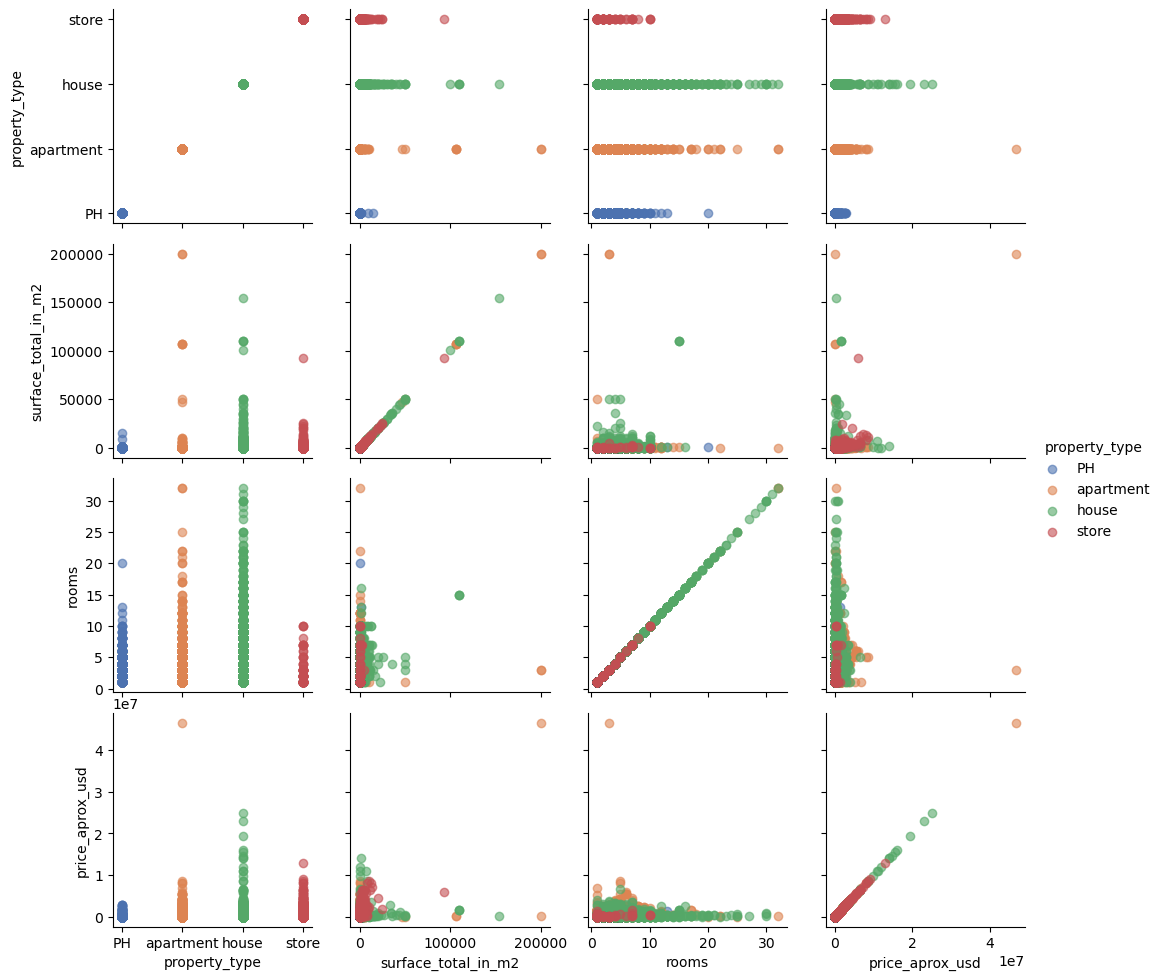

In [8]:
g = sns.PairGrid(data_tipo_usd_sup_room_T, vars=['property_type','surface_total_in_m2','rooms','price_aprox_usd'],hue='property_type', palette='deep')
g.map(plt.scatter, alpha=0.6)
g.add_legend()

#### Se puede ver una relacion entre precio tipo de departamento y superficie, no asi con la cantidad de habitaciones

*nota: cambiar a data_limpia cuando arreglemos el problema de regex de esa columna para obtener datos no influenciados por los datos faltantes

### 4-Calcular el precio total = Precio u$d/m2 * Superficie en base al punto anterior para las filas con datos faltantes

#NOTA: EVALUAR ELIMINAR LOS VALORES Q NO SON PESOS ARGENTINOS PARA PODER HACER UNA CONVERSION DE TODOS LOS VALORES A USD - PENDIENTE

Cálculo cambio entre ARS y USD 

In [ ]:
import numpy as np
change = data['price_aprox_local_currency'] / data['price_aprox_usd']
change.median()

17.6445